In [77]:
import numpy as np
import pandas as pd
import math

In [78]:
data_set = pd.read_csv("epoch_clustering_data.csv")
last_three_columns = data_set.iloc[: , -3:]
gujarat_data = last_three_columns[last_three_columns['StateName'] == "GUJARAT"].copy()
print(gujarat_data.head())
print(gujarat_data.shape)
# features = gujarat_data.iloc[: , [1,2]]
features = gujarat_data[['Latitude', 'Longitude']]

     StateName    Latitude   Longitude
1350   GUJARAT     23.6093      72.949
1351   GUJARAT   24.336149   73.125996
1353   GUJARAT  23.0279349  72.6817017
1364   GUJARAT   23.979529   72.713685
3091   GUJARAT   23.258217   72.339232
(8868, 3)


/tmp/ipykernel_9419/1688967477.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_set = pd.read_csv("epoch_clustering_data.csv")


In [79]:


class point:
    def __init__ (self , longitude , latitude):
        self.x = latitude
        self.y = longitude
        self.cluster_id = None
    
    def distance_to (self , other_point):
        return euclidian_distance(self , other_point)

def euclidian_distance (point_1 , point_2):
    return math.sqrt((point_1.x-point_2.x)**2 + (point_1.y-point_2.y)**2)

print(features.head())

        Latitude   Longitude
1350     23.6093      72.949
1351   24.336149   73.125996
1353  23.0279349  72.6817017
1364   23.979529   72.713685
3091   23.258217   72.339232


In [80]:
point_list = []

for feature in features.iterrows():
    point_list.append(point(feature[1]['Latitude'] , feature[1]['Longitude']))

print(len(point_list))

8868


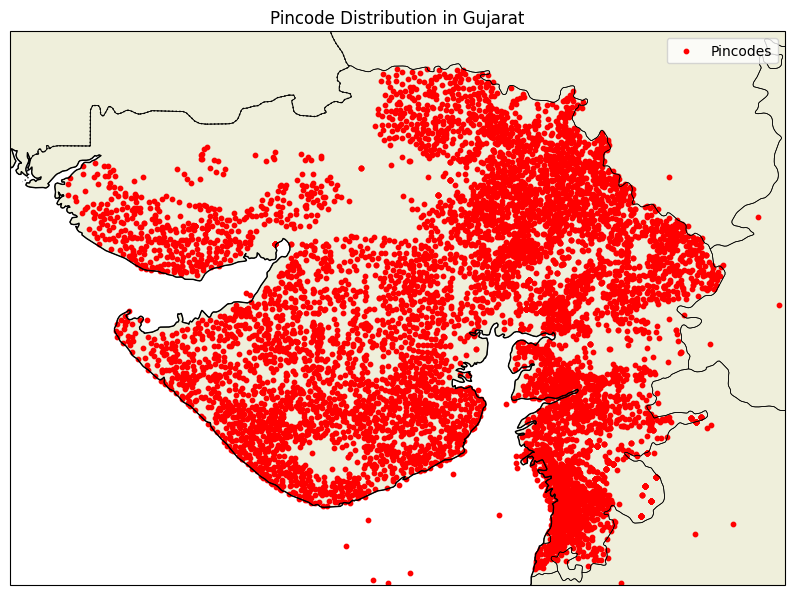

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load your DataFrame (gujarat_data)
df = gujarat_data

# Convert to float (forcefully)
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop any rows that couldn't be converted (became NaN)
df = df.dropna(subset=['Latitude', 'Longitude'])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)

ax.set_extent([68, 75, 20, 25], crs=ccrs.PlateCarree())

# 🎯 Plot now that data is clean
ax.scatter(df['Longitude'], df['Latitude'], color='red', s=10, label='Pincodes', transform=ccrs.PlateCarree())

plt.title("Pincode Distribution in Gujarat")
plt.legend()
plt.show()


In [98]:
# converting points into numpy arrays
# X = np.array([[float(point.x) ,float(point.y)] for point in point_list])  

features = gujarat_data[['Latitude', 'Longitude']]
X = features.to_numpy()

class K_means:
    def __init__ (self, n_clusters, max_iters=100, tolerance=1e-4):
        self.n_clusters = n_clusters
        self.max_iterations = max_iters
        self.tolerance = tolerance
        self.centroids = None
        self.old_centroids = None

    def initialize_centroids(self , X):
        indices = np.random.choice(len(X), self.n_clusters , replace=False ) # this randomly selects K random indexes from all the points
        self.centroids = X[indices].copy()
        self.old_centroids = X[indices].copy() # this is the list of randomly selected K points to be the centroid

    def assign_cluster (self , X):
        labels = []
        for point in X: # selected point from all the points
            least_distance = math.inf
            cluster_index = None

            for i in range(len(self.centroids)): # Now selecting every centroid sequentially
                centroid = self.centroids[i]
                # now we will compute distances of point from all the centroid
                distance = math.sqrt((point[0]-centroid[0])**2+(point[1]-centroid[1])**2)

                if distance<least_distance:
                    least_distance = distance
                    cluster_index = i

            # now we have index of closest centroid to the given point
            labels.append(cluster_index)

        return labels

    def update_centroid (self , X , labels):
        new_centroids = []
        for cluster_index in range(self.n_clusters):
            list_of_cluster_points = X[labels == cluster_index].copy()
            mean_latitude = np.mean([point[0] for point in list_of_cluster_points])
            mean_longitude = np.mean([point[1] for point in list_of_cluster_points])
            new_centroids.append([mean_latitude , mean_longitude])

        self.old_centroids = self.centroids
        self.centroids = np.array(new_centroids)

    def check_tolerance(self):
        total_movement = np.linalg.norm(self.old_centroids - self.centroids)
        return total_movement < self.tolerance
    
    def fit(self , X):
        self.initialize_centroids(X)

        for iteration in range(self.max_iterations):
            # Assign each point to the nearest centroid, labels is a list where nth index value is label of nth point's cluster
            labels = self.assign_cluster(X)

            # Store the current centroids before updating. Will be used for tolerance calculation
            self.old_centroids = self.centroids.copy()

            # Update the centroid positions based on current cluster assignments
            self.update_centroid(X, np.array(labels))

            # Check if centroids have stopped moving significantly (convergence)
            if self.check_tolerance():
                print(f"Converged in {iteration+1} iterations.")
                break

        return labels


def WCSS_calculation(X , max_k = 15):
    wcss_scores = []
    for k in range(1, max_k+1):
        kmeans = K_means(n_clusters=k)
        labels = kmeans.fit(X)
        
        # Calculate sum of squared distances to closest centroid (WCSS score)
        square_sum = 0
        for index ,point_label in enumerate(labels):
            centroid = kmeans.centroids[point_label]
            point = X[index]
            square_sum += np.sum((point[0] - centroid[0]) ** 2+(point[1] - centroid[1]) ** 2)
        wcss_scores.append(square_sum)
    return wcss_scores

def determine_optimal_k(wcss):
    """Automatically find elbow point using knee locator method"""
    from kneed import KneeLocator  # Note: This might need installation
    kl = KneeLocator(range(1, len(wcss)+1), wcss, curve='convex', direction='decreasing')
    return kl.elbow

# print(X)

Converged in 2 iterations.
Converged in 7 iterations.
Converged in 7 iterations.
Converged in 10 iterations.
Converged in 26 iterations.
Converged in 37 iterations.
Converged in 17 iterations.
Converged in 24 iterations.
Converged in 21 iterations.


/home/asit-patel/Epoch Tasks/myvenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/asit-patel/Epoch Tasks/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Converged in 37 iterations.
Converged in 43 iterations.
Converged in 63 iterations.
Converged in 33 iterations.
Converged in 82 iterations.


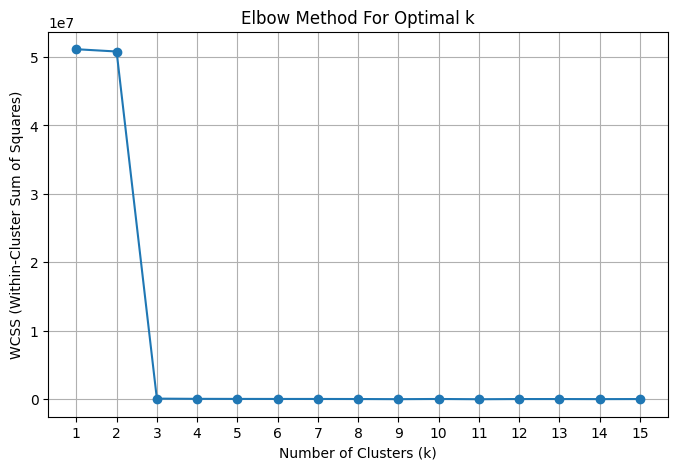

Converged in 19 iterations.


/tmp/ipykernel_9419/3026520743.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', kmeans.n_clusters)


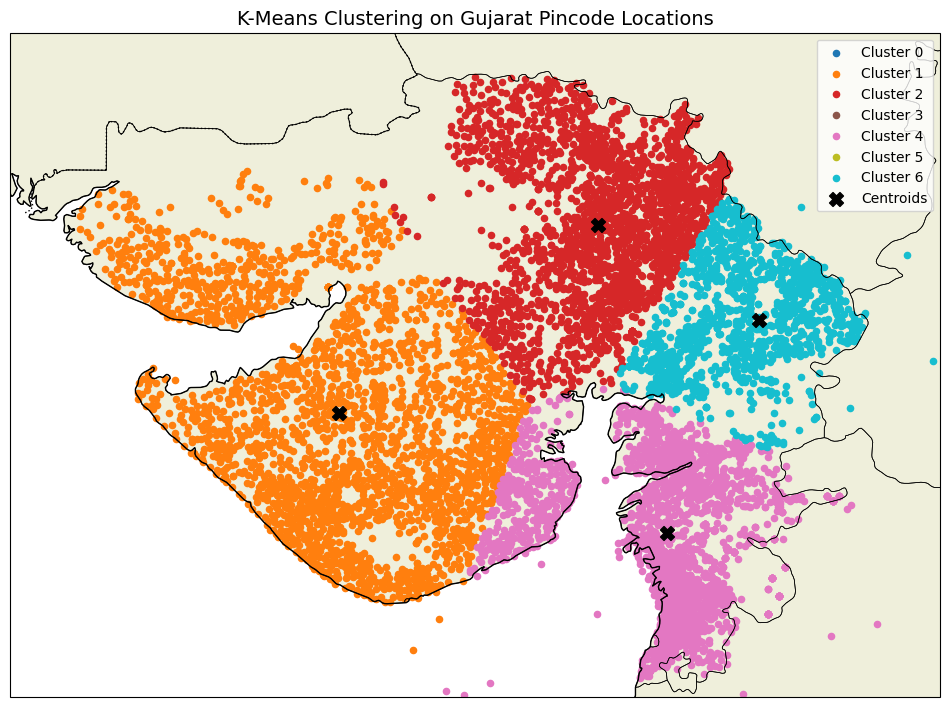


📌 Final Cluster Centroids:
Cluster 0: Latitude = 66.24899, Longitude = 21.21534
Cluster 1: Latitude = 22.13832, Longitude = 70.47865
Cluster 2: Latitude = 23.54928, Longitude = 72.42916
Cluster 3: Latitude = 23.14000, Longitude = 7192.00000
Cluster 4: Latitude = 21.23432, Longitude = 72.94687
Cluster 5: Latitude = 15.61469, Longitude = 74.24937
Cluster 6: Latitude = 22.83514, Longitude = 73.63467

📊 Cluster Distribution:
Cluster 0: 72 points
Cluster 1: 2456 points
Cluster 2: 2171 points
Cluster 3: 1 points
Cluster 4: 2135 points
Cluster 5: 666 points
Cluster 6: 1363 points


In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Make sure gujarat_data is cleaned before clustering
gujarat_data['Latitude'] = pd.to_numeric(gujarat_data['Latitude'], errors='coerce')
gujarat_data['Longitude'] = pd.to_numeric(gujarat_data['Longitude'], errors='coerce')
gujarat_data = gujarat_data.dropna(subset=['Latitude', 'Longitude'])

# Prepare data again after cleaning
features = gujarat_data[['Latitude', 'Longitude']]
X = features.to_numpy()
wcss = WCSS_calculation(X, max_k=15)
# index_of_min_WCSS = wcss.index(min(wcss))
# optimum_value_of_k = index_of_min_WCSS+1
optimal_value_of_k = determine_optimal_k(wcss)

# 📈 Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 16), wcss, marker='o', linestyle='-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 16))
plt.grid(True)
plt.show()

# Fit K-Means (if not already done)
kmeans = K_means(n_clusters=optimum_value_of_k)
labels = np.array(kmeans.fit(X))

# Final centroids
centroids = kmeans.centroids

# 🎨 Color-coded Cluster Map
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Focus on Gujarat
ax.set_extent([68, 75, 20, 25], crs=ccrs.PlateCarree())

# Color map
colors = cm.get_cmap('tab10', kmeans.n_clusters)

# Plot each cluster
for cluster_index in range(kmeans.n_clusters):
    cluster_points = X[labels == cluster_index]
    ax.scatter(
        cluster_points[:, 1],  # Longitude
        cluster_points[:, 0],  # Latitude
        color=colors(cluster_index),
        label=f"Cluster {cluster_index}",
        s=20,
        transform=ccrs.PlateCarree()
    )

# Plot centroids
ax.scatter(
    centroids[:, 1],  # Longitude
    centroids[:, 0],  # Latitude
    color='black', marker='X', s=100,
    label='Centroids', transform=ccrs.PlateCarree()
)

plt.title("K-Means Clustering on Gujarat Pincode Locations", fontsize=14)
plt.legend()
plt.show()

# 📜 Text Summary
print("\n📌 Final Cluster Centroids:")
for idx, centroid in enumerate(centroids):
    print(f"Cluster {idx}: Latitude = {centroid[0]:.5f}, Longitude = {centroid[1]:.5f}")

print("\n📊 Cluster Distribution:")
unique, counts = np.unique(labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} points")


In [94]:
# Add this after clustering (NEW)
def analyze_clusters(gujarat_data, labels, centroids):
    # Add cluster labels to original data
    gujarat_data = gujarat_data.copy()
    gujarat_data['Cluster'] = labels
    
    # Calculate cluster statistics
    cluster_stats = []
    for cluster_id in range(len(centroids)):
        cluster_data = gujarat_data[gujarat_data['Cluster'] == cluster_id]
        stats = {
            'Cluster': cluster_id,
            'Points': len(cluster_data),
            'Latitude_Mean': cluster_data['Latitude'].mean(),
            'Longitude_Mean': cluster_data['Longitude'].mean(),
            'Area_Covered': f"{cluster_data['Latitude'].max()-cluster_data['Latitude'].min():.2f}° × "
                          f"{cluster_data['Longitude'].max()-cluster_data['Longitude'].min():.2f}°",
            'Density': len(cluster_data)/(
                (cluster_data['Latitude'].max()-cluster_data['Latitude'].min()) *
                (cluster_data['Longitude'].max()-cluster_data['Longitude'].min())
            ) if (cluster_data['Latitude'].max() != cluster_data['Latitude'].min() and
                 cluster_data['Longitude'].max() != cluster_data['Longitude'].min())
            else float('inf')
        }
        cluster_stats.append(stats)
    
    # Display statistics
    stats_df = pd.DataFrame(cluster_stats)
    print("\n📊 Detailed Cluster Statistics:")
    print(stats_df.to_string(index=False))
    
    # Generate insights
    print("\n🔍 Key Insights:")
    print("1. Cluster Distribution:")
    print(f"- The optimal number of clusters was determined to be {len(centroids)} using the elbow method.")
    
    print("\n2. Geographic Patterns:")
    # Sort clusters by latitude (North to South)
    sorted_by_lat = sorted([(i, c[0]) for i, c in enumerate(centroids)], key=lambda x: x[1], reverse=True)
    print(f"- Northernmost cluster: Cluster {sorted_by_lat[0][0]} (Latitude: {sorted_by_lat[0][1]:.2f})")
    print(f"- Southernmost cluster: Cluster {sorted_by_lat[-1][0]} (Latitude: {sorted_by_lat[-1][1]:.2f})")
    
    # Identify most dense cluster
    most_dense = stats_df.loc[stats_df['Density'].idxmax()]
    print(f"\n3. Most dense cluster is Cluster {most_dense['Cluster']} with:")
    print(f"   - {most_dense['Points']} pincodes in area {most_dense['Area_Covered']}")
    print("   - Likely representing urban centers like major cities")
    
    # Identify most sparse cluster
    least_dense = stats_df.loc[stats_df['Density'].idxmin()]
    print(f"\n4. Most sparse cluster is Cluster {least_dense['Cluster']} with:")
    print(f"   - Only {least_dense['Points']} pincodes in area {least_dense['Area_Covered']}")
    print("   - Likely representing rural or less populated areas")


analyze_clusters(gujarat_data , labels , centroids)


📊 Detailed Cluster Statistics:
 Cluster  Points  Latitude_Mean  Longitude_Mean    Area_Covered    Density
       0     870      21.565455       71.557892   2.42° × 1.35° 266.878973
       1    1146      20.861754       73.126339   2.93° × 4.76°  82.272402
       2     831      21.837861       73.191373   1.24° × 1.85° 362.847032
       3     794      22.926305       73.778329   5.57° × 7.11°  20.048182
       4     328      24.668542       71.947490  46.57° × 4.84°   1.454815
       5    1178      22.868703       72.425232   1.42° × 1.56° 533.766104
       6      72      66.248992       21.215343 81.28° × 58.27°   0.015203
       7      70      17.331638       85.032499 12.40° × 14.88°   0.379348
       8     467      23.061780       69.434961   1.97° × 1.85° 128.320696
       9     803      21.553569       70.279054   1.64° × 1.67° 293.899505
      10       1      23.140000     7192.000000   0.00° × 0.00°        inf
      11     608      15.596679       73.289665   2.67° × 8.59°  26.